In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch

In [3]:
from sklearn.decomposition import PCA
import umap

In [4]:
df = pd.read_csv(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/processed/processed_reviews.csv"
)

In [5]:
df.head()

,rating,review_length_text,review_length_title,polarity_text,polarity_title,subjectivity_text,subjectivity_title,lemmatized_text,lemmatized_title,day_of_week,month,year
0,1,408,2,0.018448,-1.0,0.512241,1.0,"['travel', 'lot', 'travel', 'often', 'last', '...","['bad', 'airline']",Wednesday,11,2024
1,1,157,4,-0.060897,-1.0,0.592949,1.0,"['review', 'regard', 'af', 'book', 'economy', ...","['terrible', 'experience', 'airfrance']",Wednesday,11,2024
2,1,259,11,-0.094163,-0.6,0.488287,0.7,"['recently', 'hong', 'kong', 'paris', 'nov', '...","['extremely', 'disappointing', 'experience', '...",Tuesday,11,2024
3,1,274,1,-0.109373,-1.0,0.494012,1.0,"['wow', 'horrible', 'experience', 'I', 've', '...",['horrible'],Monday,11,2024
4,1,311,7,-0.126476,-1.0,0.485192,1.0,"['spend', 'fantastic', 'day', 'vacation', 'hon...","['bad', 'flight', 'experience', 'I', 've', 'ev...",Monday,11,2024


In [6]:
bow_vectorizer = CountVectorizer(max_features=10000, min_df=5, stop_words="english")
X_bow = bow_vectorizer.fit_transform(df["lemmatized_text"].astype(str))

df_bow = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bow_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df_bow, f)

df_bow.head()

,ability,able,aboard,absolute,absolutely,ac,accent,accept,acceptable,access,...,yes,yesterday,yogurt,york,young,yr,yvr,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
)

# Fit and transform lemmatized text
X_tfidf = tfidf_vectorizer.fit_transform(df["lemmatized_text"].astype(str))
df_tfidf = pd.DataFrame(
    X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# Save TF-IDF matrix
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df_tfidf, f)


df_tfidf.head()

,ability,able,able check,able sleep,able stretch,aboard,absolute,absolutely,ac,accent,...,yesterday,yogurt,york,young,yr,yr old,yvr,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
tokenized_reviews = [text.split() for text in df["lemmatized_text"].astype(str)]

word2vec_model = Word2Vec(
    sentences=tokenized_reviews, vector_size=100, window=5, min_count=5, workers=4
)


def get_word2vec_embeddings(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)


df["word2vec_embedding"] = df["lemmatized_text"].apply(get_word2vec_embeddings)

# Convert embeddings to a list (needed for pickle)
word2vec_embeddings = df["word2vec_embedding"].tolist()

# Save Word2Vec embeddings
word2vec_path = "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl"
with open(word2vec_path, "wb") as f:
    pickle.dump(word2vec_embeddings, f)

print(f"Word2Vec embeddings successfully saved to {word2vec_path}")

df[["word2vec_embedding"]].head()

Word2Vec embeddings successfully saved to /home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_vectorized.pkl


,word2vec_embedding
0,"[-0.030677047, 0.25568646, -0.23290765, -0.057..."
1,"[-0.04534627, 0.19583559, -0.13385262, 0.01986..."
2,"[-0.08980779, 0.1415432, -0.069826625, 0.02700..."
3,"[-0.044504628, 0.19534563, -0.13449027, 0.0078..."
4,"[-0.07302537, 0.18799856, -0.120248705, -0.016..."


In [ ]:
import torch

print("Torch CUDA available:", torch.cuda.is_available())  # Should be True
print("Torch Version:", torch.__version__)  # Should show a version with cu121
print("Number of GPUs:", torch.cuda.device_count())  # Should be at least 1
print("GPU Name:", torch.cuda.get_device_name(0))  # Should print Tesla T4

Torch CUDA available: True
Torch Version: 2.5.1+cu121
Number of GPUs: 1
GPU Name: Tesla T4


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


def get_bert_embeddings(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(
        device
    )
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].cpu().numpy().flatten()


df["bert_embedding"] = df["lemmatized_text"].apply(get_bert_embeddings)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl",
    "wb",
) as f:
    pickle.dump(df["bert_embedding"].tolist(), f)

print("BERT embeddings successfully saved to bert_vectorized.pkl")

df[["bert_embedding"]].head()

Using device: cuda
BERT embeddings successfully saved to bert_vectorized.pkl


,bert_embedding
0,"[-0.077621534, 0.80826515, 0.55355954, -0.0130..."
1,"[-0.11359086, 0.5122329, 0.3231188, -0.1074387..."
2,"[-0.12545647, 0.7030656, 0.25922322, -0.077031..."
3,"[-0.053296514, 0.7333618, 0.4154297, 0.0026567..."
4,"[-0.08132549, 0.6402263, 0.60423476, -0.025004..."


In [12]:
from sklearn.decomposition import PCA
import umap

In [13]:
pca = PCA(n_components=100)
X_tfidf_pca = pca.fit_transform(df_tfidf)

In [14]:
umap_model = umap.UMAP(n_components=2)
X_word2vec_umap = umap_model.fit_transform(df["word2vec_embedding"].tolist())

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/tfidf_pca.pkl",
    "wb",
) as f:
    pickle.dump(X_tfidf, f)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_umap.pkl",
    "wb",
) as f:
    pickle.dump(X_word2vec_umap, f)


In [16]:
df_final_vectorized = pd.DataFrame(
    {
        "tfidf_pca": list(X_tfidf_pca),
        "word2vec_umap": list(X_word2vec_umap),
        "bert_embedding": list(df["bert_embedding"]),
    }
)

with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/vectorized_text.pkl",
    "wb",
) as f:
    pickle.dump(df_final_vectorized, f)

df_final_vectorized.head()

,tfidf_pca,word2vec_umap,bert_embedding
0,"[-0.2710976232880935, 0.03761975597400334, -0....","[12.016884, 6.27769]","[-0.077621534, 0.80826515, 0.55355954, -0.0130..."
1,"[0.009526658835418002, 0.052701976531142766, 0...","[7.283606, 7.715997]","[-0.11359086, 0.5122329, 0.3231188, -0.1074387..."
2,"[-0.012620937229864073, 0.03186984309099944, 0...","[5.4724545, 9.6024685]","[-0.12545647, 0.7030656, 0.25922322, -0.077031..."
3,"[-0.021084444763404535, 0.03367019064057262, 0...","[7.486846, 7.6499305]","[-0.053296514, 0.7333618, 0.4154297, 0.0026567..."
4,"[-0.04586550715955241, 0.10633933877608544, 0....","[8.876901, 8.937403]","[-0.08132549, 0.6402263, 0.60423476, -0.025004..."


In [17]:
print(f"TF-IDF Shape: {df_tfidf.shape}")

df_tfidf.head()

TF-IDF Shape: (2560, 3891)


,ability,able,able check,able sleep,able stretch,aboard,absolute,absolutely,ac,accent,...,yesterday,yogurt,york,young,yr,yr old,yvr,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
vectorizer = TfidfVectorizer(
    max_features=10000, stop_words="english", ngram_range=(1, 2), min_df=5
)
vectorizer.fit(df["lemmatized_text"].astype(str))

feature_names = vectorizer.get_feature_names_out()
word_importance = df_tfidf.sum(axis=0)

df_tfidf_importance = pd.DataFrame(
    {"word": feature_names, "importance": word_importance}
)
df_tfidf_importance.sort_values(by="importance", ascending=False).head(20)


,word,importance
seat,seat,95.772995
good,good,91.989322
service,service,87.540091
time,time,79.613060
food,food,78.433995
paris,paris,69.098124
hour,hour,58.207322
staff,staff,56.818252
class,class,52.326456
great,great,50.197035


In [19]:
word2vec_model.save(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/word2vec_model.bin"
)

In [20]:
similar_words = [
    word.strip("[]' ") for word in word2vec_model.wv.index_to_key if "serv" in word
]
print(similar_words)


["service',", "serve',", "reservation',", 'service', "service',", "reserve',", "deserve',", "observe',", 'serve']


In [21]:
print("service" in word2vec_model.wv.key_to_index)  # Should return True or False

False


In [22]:
print(word2vec_model.wv.index_to_key[:20])

["'seat',", "'service',", "'not',", "'get',", "'time',", "'good',", "'paris',", "'food',", "'hour',", "'we',", "'would',", "'do',", "'one',", "'go',", "'make',", "'airport',", "'staff',", "'check',", "'take',", "'luggage',"]


In [23]:
print(type(df["lemmatized_text"].iloc[0]))  # Check if it's a list or string

<class 'str'>


In [24]:
import ast  # Helps convert strings to lists safely

df["lemmatized_text"] = df["lemmatized_text"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


In [25]:
from gensim.models import Word2Vec

# Ensure every review is a list of words (not a string!)
sentences = df["lemmatized_text"].tolist()

# Train Word2Vec Model
word2vec_model = Word2Vec(
    sentences=sentences, vector_size=100, window=5, min_count=1, workers=4
)

# Save Model
word2vec_model.save("../data/interim/word2vec_model.bin")


In [26]:
word2vec_model = Word2Vec.load("../data/interim/word2vec_model.bin")

# Now check the first few words
print(word2vec_model.wv.index_to_key[:20])  # Should be clean words

# Check for a word again
print("service" in word2vec_model.wv.key_to_index)  # Should return True


['seat', 'service', 'not', 'time', 'get', 'good', 'paris', 'food', 'hour', 'we', 'would', 'do', 'one', 'go', 'make', 'staff', 'airport', 'well', 'take', 'check']
True


In [27]:
import pickle

# Define paths
vector_files = {
    "TF-IDF": "../data/interim/tfidf_vectorized.pkl",
    "TF-IDF PCA": "../data/interim/tfidf_pca.pkl",
    "BoW": "../data/interim/bow_vectorized.pkl",
    "Word2Vec": "../data/interim/word2vec_vectorized.pkl",
    "Word2Vec UMAP": "../data/interim/word2vec_umap.pkl",
    "BERT": "../data/interim/bert_vectorized.pkl",
    "Vectorized Text": "../data/interim/vectorized_text.pkl",
}

# Load and check each file
for name, path in vector_files.items():
    try:
        with open(path, "rb") as f:
            data = pickle.load(f)
        print(f"\n{name} Shape: {data.shape if hasattr(data, 'shape') else len(data)}")
    except Exception as e:
        print(f"Error loading {name}: {e}")


TF-IDF Shape: (2560, 3891)

TF-IDF PCA Shape: (2560, 3891)

BoW Shape: (2560, 2181)

Word2Vec Shape: 2560

Word2Vec UMAP Shape: (2560, 2)

BERT Shape: 2560

Vectorized Text Shape: (2560, 3)


In [28]:
key_terms = [
    "service",
    "food",
    "seat",
    "entertainment",
    "cabin",
    "crew",
    "flight",
    "airline",
    "pilot",
    "plane",
    "delay",
]

for term in key_terms:
    if term in word2vec_model.wv.key_to_index:
        print(f"\nMost similar words to '{term}':")
        print(word2vec_model.wv.most_similar(term, topn=5))
    else:
        print(f"\n '{term}' not found in Word2Vec model")


Most similar words to 'service':
[('meal', 0.9950666427612305), ('wine', 0.9939961433410645), ('selection', 0.993447482585907), ('quality', 0.9930878281593323), ('entertainment', 0.9927509427070618)]

Most similar words to 'food':
[('good', 0.9978649020195007), ('excellent', 0.9963321685791016), ('entertainment', 0.9948770999908447), ('great', 0.9921094179153442), ('friendly', 0.9915323853492737)]

Most similar words to 'seat':
[('upgrade', 0.9891048073768616), ('recline', 0.9819252490997314), ('leg', 0.9794080853462219), ('premium', 0.9769539833068848), ('minneapolis', 0.9758038520812988)]

Most similar words to 'entertainment':
[('food', 0.9948770999908447), ('good', 0.9940075278282166), ('service', 0.992750883102417), ('selection', 0.9925212860107422), ('great', 0.9917374849319458)]

Most similar words to 'cabin':
[('attentive', 0.9950529932975769), ('nice', 0.994777500629425), ('quality', 0.9934534430503845), ('wine', 0.9929962158203125), ('selection', 0.9927071928977966)]

Most s

In [29]:
with open(
    "/home/azureuser/cloudfiles/code/Users/oskar.wolf/nlp_air_france_reviews/data/interim/bert_vectorized.pkl",
    "rb",
) as f:
    df_bert = pickle.load(f)

print(f"BERT Shape: {len(df_bert)} rows, {len(df_bert[0])}  dimensions")

df_bert[0][:10]

BERT Shape: 2560 rows, 768  dimensions


array([-0.07762153,  0.80826515,  0.55355954, -0.0130957 ,  0.08959281,
        0.68355757,  0.62863195,  1.2141685 , -0.19052489,  0.1750456 ],
      dtype=float32)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([df_bert[0]], [df_bert[1]])[0][0]

0.9248337

In [31]:
print(f"TF-IDF PCA Shape: {X_tfidf_pca.shape}")

TF-IDF PCA Shape: (2560, 100)


In [32]:
pca = PCA(n_components=100)
pca.fit(df_tfidf)

PCA(n_components=100)

In [33]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(
    f"Variance explained by first 100 components: {explained_variance[-1] * 100:.2f}%"
)

Variance explained by first 100 components: 25.59%


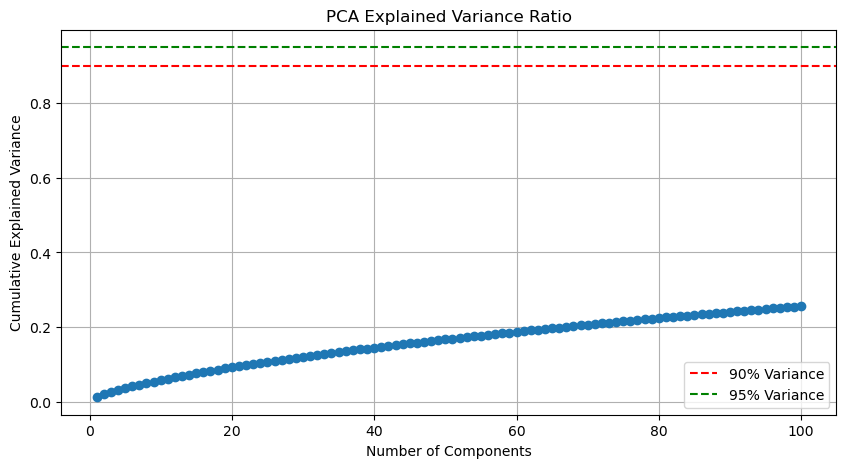

In [34]:
import matplotlib.pyplot as plt

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot variance vs number of components
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.axhline(y=0.90, color="r", linestyle="--", label="90% Variance")
plt.axhline(y=0.95, color="g", linestyle="--", label="95% Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.legend()
plt.grid()
plt.show()


In [35]:
# Find the minimum number of components needed for 90% and 95% variance
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1

print(f"Minimum components for 90% variance: {n_components_90}")
print(f"Minimum components for 95% variance: {n_components_95}")


Minimum components for 90% variance: 1
Minimum components for 95% variance: 1


In [36]:
optimal_components = n_components_90  # Use n_components_95 if needed
pca_optimal = PCA(n_components=optimal_components)
X_tfidf_pca_optimal = pca_optimal.fit_transform(df_tfidf)

# Save updated PCA-transformed data
import pickle

with open("../data/interim/tfidf_pca.pkl", "wb") as f:
    pickle.dump(X_tfidf_pca_optimal, f)

print(
    f"TF-IDF PCA Shape with {optimal_components} components: {X_tfidf_pca_optimal.shape}"
)


TF-IDF PCA Shape with 1 components: (2560, 1)


In [37]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer.fit_transform(df_tfidf)

print(f"TF-IDF UMAP Shape: {X_tfidf_umap.shape}")


/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


TF-IDF UMAP Shape: (2560, 2)


In [38]:
with open("../data/interim/tfidf_umap.pkl", "wb") as f:
    pickle.dump(X_tfidf_umap, f)
print(f"TF-IDF UMAP Data Saved! Shape: {X_tfidf_umap.shape}")

TF-IDF UMAP Data Saved! Shape: (2560, 2)


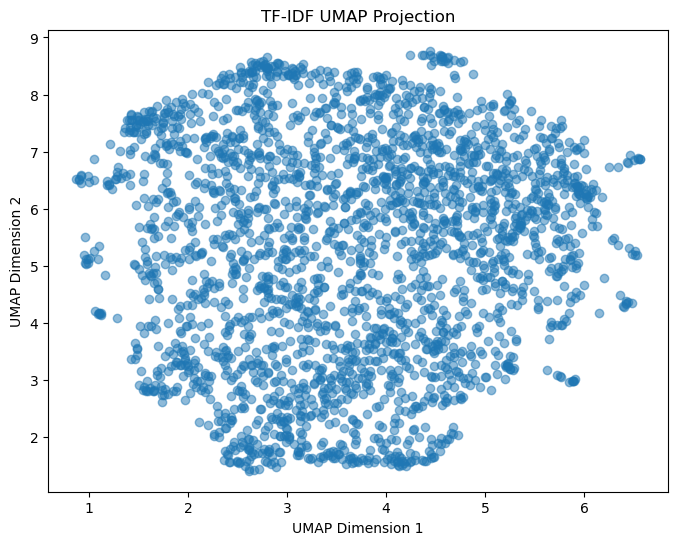

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tfidf_umap[:, 0], X_tfidf_umap[:, 1], alpha=0.5)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("TF-IDF UMAP Projection")
plt.show()

In [40]:
with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

print(f"Word2Vec UMAP Shape: {X_word2vec_umap.shape}")

Word2Vec UMAP Shape: (2560, 2)


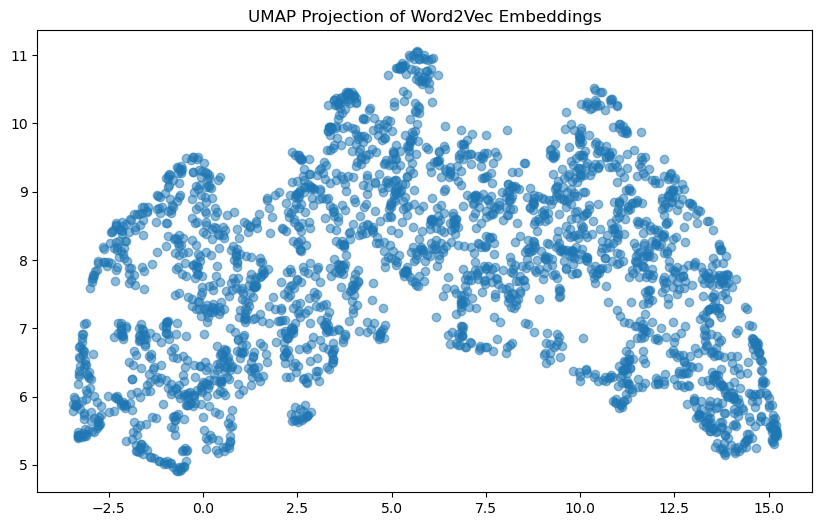

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(X_word2vec_umap[:, 0], X_word2vec_umap[:, 1], alpha=0.5)
plt.title("UMAP Projection of Word2Vec Embeddings")
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


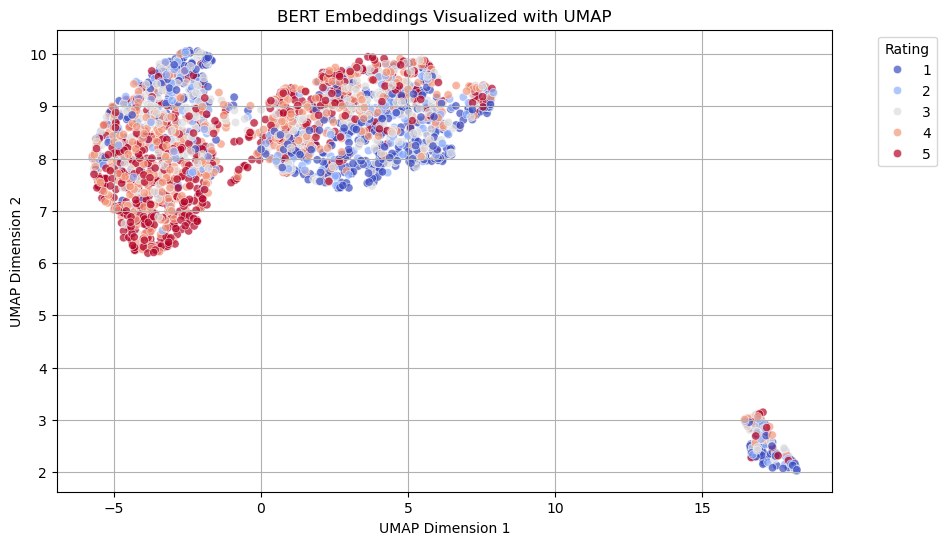

In [42]:
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state=42)
bert_umap = reducer.fit_transform(df_bert)

# Load the original dataset to get sentiment/ratings
df_reviews_path = "../data/processed/processed_reviews.csv"  # Adjust if needed
df_reviews = pd.read_csv(df_reviews_path)

# Ensure same length
df_reviews = df_reviews.iloc[: len(bert_umap)]

# Plot the UMAP representation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bert_umap[:, 0],
    y=bert_umap[:, 1],
    hue=df_reviews["rating"],
    palette="coolwarm",
    alpha=0.7,
)
plt.title("BERT Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/nlp_airfrance_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


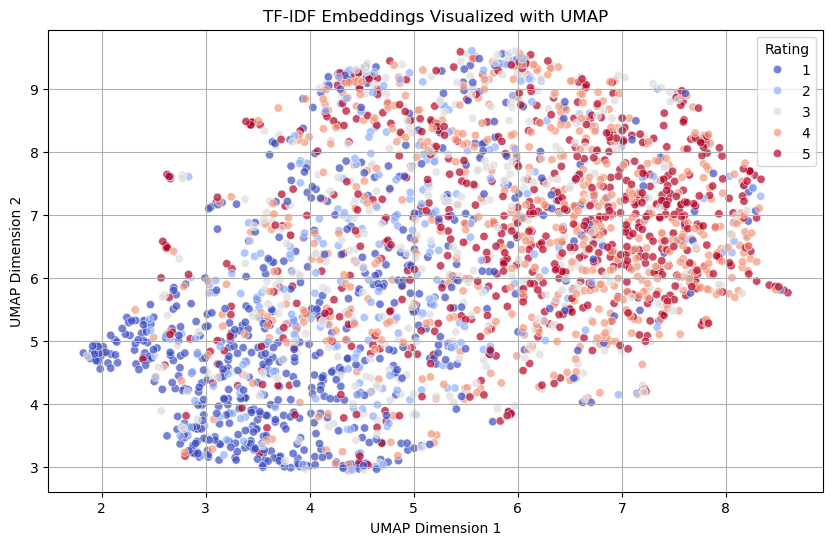

In [43]:
# Load the ratings data (ensuring alignment)
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")
ratings = df_processed["rating"]

# Apply UMAP to reduce TF-IDF dimensions to 2D
reducer_tfidf = umap.UMAP(n_components=2, random_state=42)
X_tfidf_umap = reducer_tfidf.fit_transform(X_tfidf)

# Plot UMAP for TF-IDF embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tfidf_umap[:, 0],
    y=X_tfidf_umap[:, 1],
    hue=ratings,
    palette="coolwarm",
    alpha=0.7,
)
plt.title("TF-IDF Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating")
plt.grid()
plt.show()

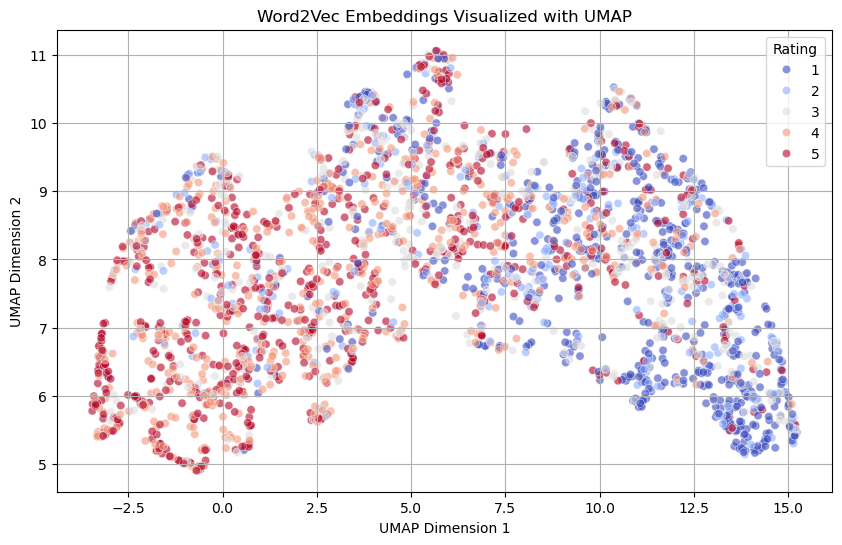

In [44]:
# Load Word2Vec UMAP embeddings
with open("../data/interim/word2vec_umap.pkl", "rb") as f:
    X_word2vec_umap = pickle.load(f)

# Load dataset to get ratings for coloring
df_processed = pd.read_csv("../data/processed/processed_reviews.csv")

# Ensure we have the correct number of rows
if X_word2vec_umap.shape[0] != df_processed.shape[0]:
    raise ValueError("Mismatch between embeddings and dataset size!")

# Plot UMAP visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_word2vec_umap[:, 0],
    y=X_word2vec_umap[:, 1],
    hue=df_processed["rating"],
    palette="coolwarm",
    alpha=0.6,
)
plt.title("Word2Vec Embeddings Visualized with UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Rating", loc="upper right")
plt.grid(True)
plt.show()